In [ ]:

import scipy
import sklearn
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import math as m
import pandas as pd
import os
from python_speech_features import mfcc, delta, logfbank
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
import csv
from scipy import signal, ndimage
from scipy.io.wavfile import read
from scipy.signal import periodogram
from scipy.ndimage import median_filter
from matplotlib import pyplot
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from google.colab import drive ## If running on google colab
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC,LinearSVC
from scipy.signal import butter,filtfilt
from scipy.signal import decimate
from google.colab import drive ## If running on google colab
import numpy as np


In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=4f4945f6dd00933e76ebb7e5e1989ab2aa33f887b5d3a68812ea38d086b6ac24
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import csv
ver='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/y_filenames.csv'
with open(ver, 'rt') as f:
    reader = csv.reader(f)
    y_label = list(reader)

In [ ]:
y_label=np.array(y_label)
print(y_label.shape)
#labelVector=y_label[:,0]
print(y_label[:,0])
labelVector=[]
for i in range(8895):
  labelVector.append(int(y_label[i][0]))


(8895, 2)
['0' '0' '0' ... '1' '1' '1']


In [ ]:
import numpy as gfg
# retrieving data from file. #(8895, 100, 39)
dir_save='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/'
loaded_arr = gfg.loadtxt(dir_save+"Features_smote.txt")

load_original_arr = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1]  // 39, 39)
  
# check the shapes:
#print("shape of arr: ", arr.shape)
print("shape of load_original_arr: ", load_original_arr.shape)


shape of load_original_arr:  (8895, 100, 39)


PREPROCESSING

In [ ]:
from scipy.io import wavfile
import scipy.signal as sps
def preprocess_cough(x,fs, cutoff = 6000, normalize = True, filter_ = True, downsample = True):
  """
  Normalize, lowpass filter, and downsample cough samples in a given data folder 
  
  Inputs: x*: (float array) time series cough signal
  fs*: (int) sampling frequency of the cough signal in Hz
  cutoff: (int) cutoff frequency of lowpass filter
  normalize: (bool) normailzation on or off
  filter: (bool) filtering on or off
  downsample: (bool) downsampling on or off
  *: mandatory input
  
  Outputs: x: (float32 array) new preprocessed cough signal
  fs: (int) new sampling frequency
  """
  
  fs_downsample = cutoff*2
  
  #Preprocess Data
  if len(x.shape)>1:
    x = np.mean(x,axis=1)                          # Convert to mono
  if normalize:
    x = x/(np.max(np.abs(x))+1e-17)                # Norm to range between -1 to 1
  if filter_:
    b, a = butter(4, fs_downsample/fs, btype='lowpass') # 4th order butter lowpass filter
    x = filtfilt(b, a, x)
  if downsample:
    #x = scipy.signal.decimate(x, int(fs/fs_downsample)) # Downsample for anti-aliasing
    #x, s = librosa.load(x, sr=20000) # Downsample 44.1kHz to 8kHz
    number_of_samples = round(len(x) * float(20000) / 48000)
    x = sps.resample(x, number_of_samples)
  
  fs_new = fs_downsample

  return np.float32(x), fs_new

In [ ]:
def segment_cough(x,fs, cough_padding=0.1,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [ ]:
ver='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/public_dataset/metadata_compiled.csv'
#metadata=metadata_pd.to_numpy()
#print(metadata[0])
with open(ver, 'rt') as f:
  reader = csv.reader(f)
  metadata = list(reader)

In [ ]:
print(len(metadata))

27551


In [ ]:
smote_data=[0]*51
s=0
smote_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/SMOTE/'
for filename in os.listdir(smote_folder):
  for line in metadata:
    if filename[:36]==line[0]:
      smote_data=np.vstack((smote_data,line))


In [ ]:

smote_data=smote_data[1:][:]
SMOTE_DATA=np.vstack((metadata[0],smote_data))

51
8895


Feature Extraction

In [ ]:
#Both networks achieved the best results on the
#feature set where features were extracted from 100 windows with a window
#length 25 ms, for each recording.
T=100
from python_speech_features import mfcc
import librosa
import math
#Set number of windows and window length
winlen = 0.025
num_windows = 100
features_list=[]
segment=[]
all_segments=[]
verified_data=SMOTE_DATA
COVID=1
HEALTHY=0
labelVector=[]
index_name=0 #verified_data[0].index('uuid')
index_status=10 #verified_data[0].index('status')
smote_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/SMOTE/'
filenames=[]
s=0
for filename in os.listdir(smote_folder):
  segment=[]
  all_segments=[]
  signal,sr=librosa.load(smote_folder+filename,sr =20000)
  fs_pre=sr
  signal_pre=signal
  segment,mask=segment_cough(signal_pre,fs_pre,cough_padding=0.1,min_cough_len=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)
  #f_down=sr
  #if len(segment)==0:
  #  print(filename)
  if len(segment)>1:
    for line in segment:
      all_segments=np.append(all_segments,line) #all the segments in one row from each file, one segment=one cough 
  elif len(segment)==1:
    all_segments=np.array(segment[0])
  overlap=math.ceil(len(all_segments)/(num_windows))
  mfccs=mfcc(all_segments,sr, numcep =13,winlen =winlen,winstep=overlap /sr)
  deltas = delta(mfccs, 2)
  delta_deltas = delta(deltas, 2)
  concat_feat = np.concatenate((mfccs, deltas, delta_deltas), axis=1)
  if len(concat_feat)>100:
    concat_feat=concat_feat[:100]
  elif len(concat_feat)<100:
    missing_samples=100-len(concat_feat)
    pad=np.zeros((missing_samples,39))
    concat_feat=np.vstack((concat_feat,pad))
  features_list.append(concat_feat)
  filenames.append(filename)

  

In [ ]:
co=0
he=0
filename_label=[]
labelVector=[]
for filename in filenames:
  filename_label.append(filename)
  #found_index = np.argmax(np.logical_and(smote_data[:,0]==[filename[:36]]))
  #print(smote_data[:,0]==[filename[:36]])                  
  #if smote_data[found_index][index_status]=='COVID-19':
  #  print(c)
  for i in range(0,len(smote_data)):
    if smote_data[i][index_name]==filename[:36]:
      if smote_data[i][index_status]=='COVID-19':
        co+=1
        #print(co)
        labelVector.append(COVID)
      elif smote_data[i][index_status]=='healthy':
        he+=1
        labelVector.append(HEALTHY)
#      else:
#        print(filename)
print(co)
print(he)

695
8200


In [ ]:
feature_matrix=[]
features_list=np.array(features_list)
print(features_list.shape)
#Efor i in range(1390):
# print(features_list[i].shape)
#  feature_matrix.append(features_list[i])
#
Featuress=features_list
#print(labelVector)
label_with_filename=np.column_stack((labelVector,filenames))
#print(len(filenames))
print(len(labelVector))

In [ ]:

import numpy as gfg
dir_save='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/'  
  
arr = Featuress
# reshaping the array from 3D
# matrice to 2D matrice.
arr_reshaped = arr.reshape(arr.shape[0], -1)
  
# saving reshaped array to file.
gfg.savetxt(dir_save+"Features_smote.txt", arr_reshaped)

# retrieving data from file.
loaded_arr = gfg.loadtxt(dir_save+"Features_smote.txt")
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // arr.shape[2], arr.shape[2])
  
# check the shapes:
print("shape of arr: ", arr.shape)
print("shape of load_original_arr: ", load_original_arr.shape)
  
# check if both arrays are same or not:
if (load_original_arr == arr).all():
    print("Yes, both the arrays are same")
else:
    print("No, both the arrays are not same")
if (loaded_arr2 == arr2).all():
    print("Yes, both the arrays are same")
else:
    print("No, both the arrays are not same")

In [ ]:
#split the data first
Featuress=load_original_arr
#y_label
x_train, x_test, y_train, y_test = train_test_split(Featuress,y_label,test_size=0.20)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
Y_TEST_FILENAMES=y_test[:,1]
y_test=y_test[:,0]
y_train=y_train[:,0]
y_val=y_val[:,0]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
# fit on the training dataset
#scaler.fit(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
# scale the training dataset
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

# scale the test dataset
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
x_val=scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

In [ ]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [ ]:
dir_save='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/' 
import pandas as pd 
pd.DataFrame(Y_TEST_FILENAMES).to_csv(dir_save+"y_test_SMOTE_after_fix_scaling.csv",header=None, index=None)

In [ ]:
from sklearn.preprocessing import StandardScaler
Featuress=load_original_arr
scaler=StandardScaler()
tryyy=scaler.fit_transform(Featuress.reshape(-1, Featuress.shape[-1])).reshape(Featuress.shape)
X=tryyy
y=labelVector

In [ ]:
print(X.shape)
#np.save(dir_save+"features_smote", X)
print(len(labelVector))

(1620, 100, 39)
8895


SMOTE

In [ ]:
#SPLITTING THE DATA 
x_test=[]
x_train=[]
x_val=[]
y_test=[]
y_train=[]
y_val=[]
x_train, x_test, y_train, y_test = train_test_split(X, labelVector,test_size=0.20) #label_with_filename, test_size=0.20)
#Y_TEST_FILENAMES=y_test[:,1]
#y_test=y_test[:,0]
#y_train=y_train[:,0]
#Split into training and validation sets
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
print(x_train.shape)
y_train=np.array(y_train) 
print(y_train.shape)
y_val=np.array(y_val) 
print(y_val.shape)
print(x_val.shape)
print(x_test.shape)
y_test=np.array(y_test) 
print(y_test.shape)

(7116, 100, 39)
(7116,)
(890,)
(890, 100, 39)
(889, 100, 39)
(889,)


In [ ]:
#x_trainN, x_testN, y_trainN, y_testN = train_test_split(X, label_with_filename, test_size=0.10)

In [ ]:
#print(y_testN.shape)
#print(y_test)
#Y_TEST_FILENAMES=y_testN[:,1]
#np.savetxt(dir_save+"y_test_SMOTE.csv", Y_TEST_FILENAMES)
dir_save='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/' 
import pandas as pd 
pd.DataFrame(Y_TEST_FILENAMES).to_csv(dir_save+"y_test_SMOTE.csv",header=None, index=None)
print(Y_TEST_FILENAMES)

['0b9f35c3-a4b1-4e69-af1c-8c7f3402d531.wav'
 '4afb3c5f-9d50-4e81-84ae-aab7d5ea9fc9.wav'
 '913141ad-f345-477b-84db-c6dfa8eba548.wav' ...
 '39033706-e96b-4e3a-a480-08da7197798d.wav'
 '75540112-dbdb-4dbc-9712-fc568d3c2506.wav'
 '3d50b1a8-1d08-47e4-9382-2fe2520cd296.wav']


In [ ]:
#x_train, y_train = zip(*train_dataset)
#x_test, y_test = zip(*test_dataset)
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
dim_1 = np.array(x_train).shape[0]
dim_2 = np.array(x_train).shape[1]
dim_3 = np.array(x_train).shape[2]

new_dim = dim_1 * dim_2

new_x_train = np.array(x_train).reshape(new_dim, dim_3)


new_y_train = []
for i in range(len(y_train)):
    # print(y_train[i])
    new_y_train.extend([y_train[i]]*dim_2)

new_y_train = np.array(new_y_train)

# transform the dataset
oversample1 = SMOTE()
X_Train, Y_Train = oversample1.fit_resample(new_x_train, new_y_train)
# summarize the new class distribution
counter = Counter(Y_Train)
print('The number of samples in TRAIN: ', counter)



x_train_SMOTE = X_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2, dim_3)

y_train_SMOTE = []
for i in range(int(X_Train.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Train.reshape(int(X_Train.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_train_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n')
    


dim_1 = np.array(x_test).shape[0]
dim_2 = np.array(x_test).shape[1]
dim_3 = np.array(x_test).shape[2]

new_dim = dim_1 * dim_2

new_x_test = np.array(x_test).reshape(new_dim, dim_3)


new_y_test = []
for i in range(len(y_test)):
    # print(y_train[i])
    new_y_test.extend([y_test[i]]*dim_2)

new_y_test = np.array(new_y_test)

# transform the dataset
oversample2 = SMOTE()
X_Test, Y_Test = oversample2.fit_resample(new_x_test, new_y_test)
# summarize the new class distribution
counter = Counter(Y_Test)
print('The number of samples in TEST: ', counter)



x_test_SMOTE = X_Test.reshape(int(X_Test.shape[0]/dim_2), dim_2, dim_3)

y_test_SMOTE = []
for i in range(int(X_Test.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Test.reshape(int(X_Test.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_test_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN TEST ******\n\n')
#VALIDATION SET

dim_1 = np.array(x_val).shape[0]
dim_2 = np.array(x_val).shape[1]
dim_3 = np.array(x_val).shape[2]

new_dim = dim_1 * dim_2

new_x_val = np.array(x_val).reshape(new_dim, dim_3)


new_y_val = []
for i in range(len(y_val)):
    # print(y_train[i])
    new_y_val.extend([y_val[i]]*dim_2)

new_y_val = np.array(new_y_val)

# transform the dataset
oversample3 = SMOTE()
X_Val, Y_Val = oversample3.fit_resample(new_x_val, new_y_val)
# summarize the new class distribution
counter = Counter(Y_Val)
print('The number of samples in VALIDATION: ', counter)



x_val_SMOTE = X_Val.reshape(int(X_Val.shape[0]/dim_2), dim_2, dim_3)

y_val_SMOTE = []
for i in range(int(X_Val.shape[0]/dim_2)):
    # print(i)
    value_list = list(Y_Val.reshape(int(X_Val.shape[0]/dim_2), dim_2)[i])
    # print(list(set(value_list)))
    y_val_SMOTE.extend(list(set(value_list)))
    ## Check: if there is any different value in a list 
    if len(set(value_list)) != 1:
        print('\n\n********* STOP: THERE IS SOMETHING WRONG IN VALIDATION ******\n\n')

The number of samples in TRAIN:  Counter({'0': 656600, '1': 656600})
The number of samples in TEST:  Counter({'0': 82100, '1': 82100})
The number of samples in VALIDATION:  Counter({'0': 81300, '1': 81300})


In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D,MaxPool2D,Dropout,Activation, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow import keras
from tensorflow.keras import layers
y_test_SMOTE=np.array(y_test_SMOTE)
x_val_SMOTE=np.array(x_val_SMOTE)
x_test_SMOTE=np.array(x_test_SMOTE)
x_train_SMOTE=np.array(x_train_SMOTE)
y_train_SMOTE=np.array(y_train_SMOTE)
y_val_SMOTE=np.array(y_val_SMOTE)
print(x_val_SMOTE.shape)
print(x_test_SMOTE.shape)
print(x_train_SMOTE.shape)
print(y_test_SMOTE.shape)
#X_Test, Y_Test=np.array(X_train),np.array(y_train)
#X_Val, Y_Val
#X_val=np.array(X_val)
#y_val=np.array(y_val)

(1626, 100, 39)
(1642, 100, 39)
(13132, 100, 39)
(1642,)


testing with imbalanced dataset

In [ ]:
input_shape=(x_train_SMOTE.shape[1],x_train_SMOTE.shape[2])
#For coughvid features:
LSTM_model = Sequential()
LSTM_model.add(LSTM(32,input_shape=input_shape))
#for coughvid
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(32,activation='relu'))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model._name = 'lstm_model'
LSTM_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:

y_test_INT=[0]*len(y_test)
for i in range(len(y_test)):
  y_test_INT[i]=int(y_test[i])

              precision    recall  f1-score   support

     healthy       0.92      0.99      0.95       821
    COVID-19       0.00      0.00      0.00        68

    accuracy                           0.91       889
   macro avg       0.46      0.49      0.48       889
weighted avg       0.85      0.91      0.88       889



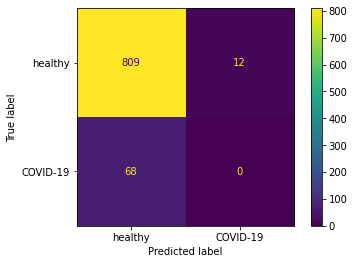

In [ ]:
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_LSTM=0
y_pred_LSTM=LSTM_model.predict(x_test)
y_pred_LSTM = (y_pred_LSTM > 0.5)
cm_LSTM = confusion_matrix(y_test_INT,y_pred_LSTM)
display_labels=['healthy','COVID-19']
conf_matrix = confusion_matrix(y_test_INT, y_pred_LSTM)
#print(Y_predict)
print(classification_report(y_test_INT,y_pred_LSTM,target_names=display_labels))
print(ConfusionMatrixDisplay(cm_LSTM,display_labels=display_labels).plot(values_format='.0f'))

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.505


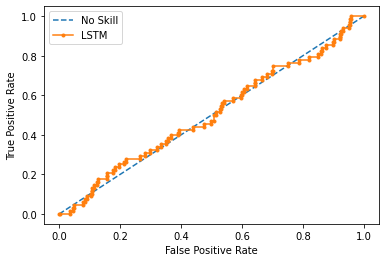

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import f1_score,roc_auc_score
y_test=y_test_INT
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
y_pred_LSTM=LSTM_model.predict(x_test)
lr_probs= y_pred_LSTM
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
print(x_val_SMOTE.shape)
print(y_val_SMOTE.shape)
print(x_train_SMOTE.shape)
print(y_train_SMOTE.shape)
print(x_test_SMOTE.shape)
print(y_test_SMOTE.shape)

(1644, 100, 39)
(1644,)
(13108, 100, 39)
(13108,)
(1648, 100, 39)
(1648,)


In [ ]:
y_val_SMOTE_INT=[0]*len(y_val_SMOTE)
for i in range(len(y_val_SMOTE)):
  y_val_SMOTE_INT[i]=int(y_val_SMOTE[i])


y_train_SMOTE_INT=[0]*len(y_train_SMOTE)
for i in range(len(y_train_SMOTE)):
  y_train_SMOTE_INT[i]=int(y_train_SMOTE[i])



y_test_SMOTE_INT=[0]*len(y_test_SMOTE)
for i in range(len(y_test_SMOTE)):
  y_test_SMOTE_INT[i]=int(y_test_SMOTE[i])


print(type(y_val_SMOTE_INT))
print(type(y_train_SMOTE_INT))
y_val_SMOTE_INT = np.array(y_val_SMOTE_INT)
y_train_SMOTE_INT=np.array(y_train_SMOTE_INT)

<class 'list'>
<class 'list'>


In [ ]:
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
historyyy=LSTM_model.fit(x_train_SMOTE,y_train_SMOTE_INT,validation_data=(x_val_SMOTE,y_val_SMOTE_INT),batch_size= 128,epochs=200,callbacks=es)

Epoch 1/200
103/103 [==============================] - 10s 73ms/step - loss: 0.4192 - accuracy: 0.8236 - val_loss: 0.1732 - val_accuracy: 0.9502
Epoch 2/200
103/103 [==============================] - 7s 68ms/step - loss: 0.1584 - accuracy: 0.9566 - val_loss: 0.1676 - val_accuracy: 0.9520
Epoch 3/200
103/103 [==============================] - 7s 67ms/step - loss: 0.1477 - accuracy: 0.9580 - val_loss: 0.1646 - val_accuracy: 0.9520
Epoch 4/200
103/103 [==============================] - 7s 68ms/step - loss: 0.1451 - accuracy: 0.9581 - val_loss: 0.1635 - val_accuracy: 0.9526
Epoch 5/200
103/103 [==============================] - 7s 68ms/step - loss: 0.1446 - accuracy: 0.9582 - val_loss: 0.1639 - val_accuracy: 0.9526
Epoch 6/200
103/103 [==============================] - 7s 68ms/step - loss: 0.1430 - accuracy: 0.9581 - val_loss: 0.1639 - val_accuracy: 0.9526
Epoch 7/200
103/103 [==============================] - 7s 68ms/step - loss: 0.1394 - accuracy: 0.9583 - val_loss: 0.1653 - val_accuracy

              precision    recall  f1-score   support

     healthy       0.91      0.96      0.94       812
    COVID-19       0.96      0.91      0.93       812

    accuracy                           0.93      1624
   macro avg       0.94      0.93      0.93      1624
weighted avg       0.94      0.93      0.93      1624



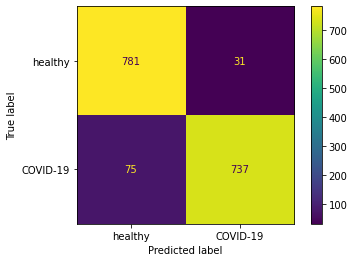

In [ ]:
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_LSTM=0
y_pred_LSTM=LSTM_model.predict(x_test_SMOTE)
y_pred_LSTM = (y_pred_LSTM > 0.5)
cm_LSTM = confusion_matrix(y_test_SMOTE_INT,y_pred_LSTM)
display_labels=['healthy','COVID-19']
conf_matrix = confusion_matrix(y_test_SMOTE_INT, y_pred_LSTM)
#print(Y_predict)
print(classification_report(y_test_SMOTE_INT,y_pred_LSTM,target_names=display_labels))
print(ConfusionMatrixDisplay(cm_LSTM,display_labels=display_labels).plot(values_format='.0f'))

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.952


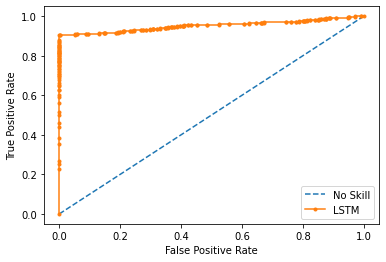

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import f1_score,roc_auc_score
y_test=y_test_SMOTE_INT
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
X_test=x_test_SMOTE
y_pred_LSTM=LSTM_model.predict(X_test)
lr_probs= y_pred_LSTM
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_test_INT=[0]*len(y_test)
for i in range(len(y_test)):
  y_test_INT[i]=int(y_test[i])



In [ ]:
#for i in range(len(x_test)):
#  x_test_INT[i]=int(x_test[i])
print(x_test.shape)

print(len(y_test_INT))

(889, 100, 39)
1624


              precision    recall  f1-score   support

     healthy       0.97      0.99      0.98       820
    COVID-19       0.83      0.58      0.68        69

    accuracy                           0.96       889
   macro avg       0.90      0.78      0.83       889
weighted avg       0.96      0.96      0.95       889



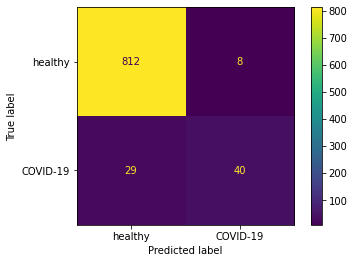

In [ ]:

y_pred_LSTM=0
y_pred_LSTM=LSTM_model.predict(x_test)
y_pred_LSTM = (y_pred_LSTM > 0.5)
cm_LSTM = confusion_matrix(y_test_INT,y_pred_LSTM)
display_labels=['healthy','COVID-19']
conf_matrix = confusion_matrix(y_test_INT, y_pred_LSTM)
#print(Y_predict)
print(classification_report(y_test_INT,y_pred_LSTM,target_names=display_labels))
print(ConfusionMatrixDisplay(cm_LSTM,display_labels=display_labels).plot(values_format='.0f'))

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.869


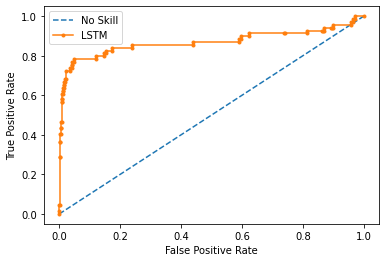

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import f1_score,roc_auc_score
y_test=y_test_INT
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
X_test=x_test
y_pred_LSTM=LSTM_model.predict(X_test)
lr_probs= y_pred_LSTM
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
LSTM_model.save('LSTM_SMOTE_after_fix_scaling.h5')

In [ ]:
#loss_train = history.history['accuracy']
#loss_val = history.history['val_accuracy']
#epochs = range(1,35)
#plt.plot(epochs, loss_train, 'g', label='Training accuracy')
#plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.plot(historyyy.history['accuracy'],label='Training accuracy')
plt.plot(historyyy.history['val_accuracy'],label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

LSTM TESTING 

In [ ]:
dir='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/SMOTE/'
s=0
import shutil
#dest_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/50%SMOTE/ALL_DATA'
new_dest='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/TEST_UBALANCED/TEST_WAV'
for filename in os.listdir(dir):
  for line in verified_data:
    #print(line[0][:36])
    if filename[:36]==line[0][:36]:
      s+=1
      shutil.copy(dir+filename, new_dest)

In [ ]:
print(s)

889


In [ ]:
#Both networks achieved the best results on the
#feature set where features were extracted from 100 windows with a window
#length 25 ms, for each recording.
T=100
from python_speech_features import mfcc
import librosa
import math
#Set number of windows and window length
winlen = 0.025
num_windows = 100
features_list=[]
segment=[]
all_segments=[]
#verified_data=SMOTE_DATA
COVID=1
HEALTHY=0
labelVector=[]
index_name=0 #verified_data[0].index('uuid')
index_status=10 #verified_data[0].index('status')
#smote_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/SMOTE/'
smote_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/TEST_UBALANCED/TEST_WAV/'
filenames=[]
s=0
for filename in os.listdir(smote_folder):
  #print(filename)
  s+=1
  #print(s)
  segment=[]
  all_segments=[]
  #print(filename)
  signal,sr=librosa.load(smote_folder+filename,sr =20000)
  signal_pre,fs_pre=preprocess_cough(signal,fs=sr, cutoff = 10000, normalize = True, filter_ =False, downsample = False)
  fs_pre=sr
  segment,mask=segment_cough(signal_pre,fs_pre,cough_padding=0.1,min_cough_len=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)
  #f_down=sr
  #if len(segment)==0:
  #  print(filename)
  if len(segment)>1:
    for line in segment:
      all_segments=np.append(all_segments,line) #all the segments in one row from each file, one segment=one cough 
  elif len(segment)==1:
    all_segments=np.array(segment[0])
  if all_segments==[]:
    all_segments=signal_pre
  overlap=math.ceil(len(all_segments)/(num_windows))
  mfccs=mfcc(all_segments,sr, numcep =13,winlen =winlen,winstep=overlap /sr)
  deltas = delta(mfccs, 2)
  delta_deltas = delta(deltas, 2)
  concat_feat = np.concatenate((mfccs, deltas, delta_deltas), axis=1)
  if len(concat_feat)>100:
    concat_feat=concat_feat[:100]
  elif len(concat_feat)<100:
    missing_samples=100-len(concat_feat)
    pad=np.zeros((missing_samples,39))
    concat_feat=np.vstack((concat_feat,pad))
  features_list.append(concat_feat)
  filenames.append(filename)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Colab Notebooks/ORGANIZE/Random testfiles/')))

50


In [ ]:
smote_data=[0]*51
s=0
smote_folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/TEST_UBALANCED/TEST_WAV'
for filename in os.listdir(smote_folder):
  for line in metadata:
    if filename[:36]==line[0]:
      smote_data=np.vstack((smote_data,line))


In [ ]:
print(len(metadata[0]))
print(len(smote_data[1:][:]))
smote_data=smote_data[1:][:]
SMOTE_DATA=np.vstack((metadata[0],smote_data))
print(smote_data)

51
889
[['de56597b-1229-4fd0-9781-c46681b35bb7'
  '2020-04-13T21:32:11.744842+00:00' '0.975' ... '' '' '']
 ['dea176dc-0de5-4b4c-bfa2-ef80ffe96fec'
  '2020-07-20T19:16:49.767454+00:00' '0.9981' ... '' '' '']
 ['df8ccb4f-7462-4b6d-92f6-a9ca6e333a63'
  '2020-04-12T09:51:12.223249+00:00' '0.9755' ... '' '' '']
 ...
 ['a0bd7465-ae76-40cd-903b-3591ed9595db'
  '2020-04-14T17:17:50.943891+00:00' '1' ... '' '' '']
 ['ac4ea2db-4fff-4a7f-a5fe-3a9ade2f1020'
  '2020-04-14T13:46:37.446584+00:00' '1' ... '' '' '']
 ['af89b4c6-a942-4dbd-9efb-cc0ae79a9acf'
  '2020-04-20T08:50:45.717915+00:00' '1' ... '' '' '']]


In [ ]:
co=0
he=0
filename_label=[]
labelVector=[]
for filename in filenames:
  filename_label.append(filename)
  #found_index = np.argmax(np.logical_and(smote_data[:,0]==[filename[:36]]))
  #print(smote_data[:,0]==[filename[:36]])                  
  #if smote_data[found_index][index_status]=='COVID-19':
  #  print(c)
  for i in range(0,len(smote_data)):
    if smote_data[i][index_name]==filename[:36]:
      if smote_data[i][index_status]=='COVID-19':
        co+=1
        #print(co)
        labelVector.append(COVID)
      elif smote_data[i][index_status]=='healthy':
        he+=1
        labelVector.append(HEALTHY)
#      else:
#        print(filename)
print(co)
print(he)

69
820


In [ ]:
feature_matrix=[]
features_list=np.array(features_list)
print(features_list.shape)
#Efor i in range(1390):
# print(features_list[i].shape)
#  feature_matrix.append(features_list[i])
#
#Featuress=features_list

(889, 100, 39)


In [ ]:
X=features_list
y=labelVector

In [ ]:
import pickle
scalerfile='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/scaler (2).sav'
scaler=pickle.load(open(scalerfile,'rb'))
tryyy=scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
X=tryyy
y=labelVector

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/ORGANIZE/LSTM_SMOTE_after_fix_scaling-2.h5')

In [ ]:
y_pred_LSTM=model.predict(X)
y_pred_LSTM = (y_pred_LSTM > 0.5)

              precision    recall  f1-score   support

     healthy       0.96      0.32      0.48       820
    COVID-19       0.09      0.84      0.17        69

    accuracy                           0.36       889
   macro avg       0.53      0.58      0.33       889
weighted avg       0.89      0.36      0.46       889



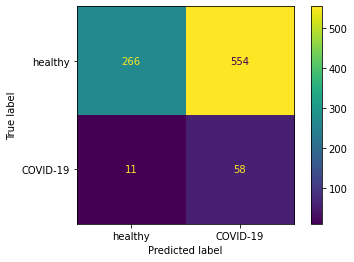

In [ ]:
#y_pred_LSTM=0
y_pred_LSTM=LSTM_model.predict(X)
y_pred_LSTM = (y_pred_LSTM > 0.5)
cm_LSTM = confusion_matrix(y,y_pred_LSTM)
display_labels=['healthy','COVID-19']
conf_matrix = confusion_matrix(y, y_pred_LSTM)
#print(Y_predict)
print(classification_report(y,y_pred_LSTM,target_names=display_labels))
print(ConfusionMatrixDisplay(cm_LSTM,display_labels=display_labels).plot(values_format='.0f'))